In [74]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

sn.set_style("white")
plt.rc("figure", figsize=(13, 9))
plt.rc("font", size=12)
plt.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['svg.fonttype'] = 'none'

In [ ]:
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["svg.fonttype"] = "none"
sn.set_style("white")

# Paths 
VAR        = "precip"  # adjust this for the different vars  
DELTA_PATH = f"/mnt/data/romi/output/paper_1/output_{VAR}_final/out_{VAR}.zarr"         
TS_PATH    = f"/mnt/data/romi/output/paper_1/output_{VAR}_final/out_{VAR}_ts.zarr"      
KT_PATH    = f"/mnt/data/romi/output/paper_1/output_{VAR}_final/out_{VAR}_kt.zarr"
MC_PATH    = f"/mnt/data/romi/output/paper_1/output_{VAR}_final/out_{VAR}_meanchange.zarr"   
                        
ALPHA_KT   = 0.05

# delta and TS significance 
# if a boolean sig or numeric pval var exists use it
# otherwise use a quantile based threshold 
DELTA_FALLBACK_Q = 0.975     
TS_FALLBACK_Q    = 0.975     
MC_FALLBACK_Q    = 0.975     

INDICATORS = [("ac1","AC1"), ("std","SD"), ("skew","Skew"), ("kurt","Kurt"), ("fd","FD")]

def open_and_align(delta_path = DELTA_PATH, ts_path = TS_PATH, kt_path = KT_PATH, mc_path = MC_PATH): 


    def open_any(path):
        if os.path.isdir(path): return xr.open_zarr(path)
        return xr.open_dataset(path)

    ds_delta = open_any(delta_path)
    ds_ts    = open_any(ts_path)
    ds_kt    = open_any(kt_path)
    ds_mc    = open_any(mc_path)

   
    ds_delta, ds_ts, ds_kt, ds_mc = xr.align(ds_delta, ds_ts, ds_kt, ds_mc, join="inner")

    return ds_delta, ds_ts, ds_kt, ds_mc


def sign_to_class(x):
    """Return -1, 0, +1 from numeric array based on sign"""
    return xr.where(x > 0, 1, xr.where(x < 0, -1, 0))

def classify_kt(ds_kt, var, suf, alpha=ALPHA_KT):
    tau  = ds_kt[f"{var}_{suf}_kt"]
    pval = ds_kt[f"{var}_{suf}_pval"]
    sig = (pval < alpha)
    return sign_to_class(tau).where(sig, 0)

def classify_ts(ds_ts, var, suf, q=TS_FALLBACK_Q):
    slope = ds_ts.get(f"{var}_{suf}_ts")
    if slope is None:
        return xr.full_like(ds_ts[list(ds_ts.data_vars)[0]].isel({list(ds_ts.dims)[0]:0}), 0)  # empty 0s
    sig_name = f"{var}_{suf}_ts_sig"
    if sig_name in ds_ts:
        sig = ds_ts[sig_name] > 0
    else:
        thr = float(np.nanquantile(np.abs(slope.values), q))
        sig = np.abs(slope) > thr
    return sign_to_class(slope).where(sig, 0)

def classify_delta(ds_delta, var, suf, q=DELTA_FALLBACK_Q):
    base = ds_delta.get(f"{var}_delta_{suf}")
    if base is None:
        return xr.full_like(ds_delta[list(ds_delta.data_vars)[0]].isel({list(ds_delta.dims)[0]:0}), 0)
   
    sig_name = f"{var}_delta_{suf}_sig"
    p_name   = f"{var}_delta_{suf}_pval"
    if sig_name in ds_delta:
        sig = ds_delta[sig_name].astype(bool)
    elif p_name in ds_delta:
        sig = ds_delta[p_name] < 0.05
    else:
        thr = float(np.nanquantile(np.abs(base.values), q))
        sig = np.abs(base) > thr
    return sign_to_class(base).where(sig, 0)

def classify_mc(ds_mc, var, suf, q = MC_FALLBACK_Q): 

    meanchange = ds_mc.get(f"{var}_{suf}_mean_change")

    if meanchange is None:
        return xr.full_like(ds_mc[list(ds_mc.data_vars)[0]].isel({list(ds_mc.dims)[0]:0}), 0) 
    
    sig_name = f"{var}_{suf}_mean_change_sig"
    p_name = f"{var}_{suf}_ttest_p"

    if sig_name in ds_mc:
        sig = ds_mc[sig_name].astype(bool)
    elif p_name in ds_mc:
        sig = ds_mc[p_name] < 0.05
    else:
        thr = float(np.nanquantile(np.abs(meanchange.values), q))
        sig = np.abs(meanchange) > thr
    return sign_to_class(meanchange).where(sig, 0)


def _to_numpy(da):
    """return a numpy array from xarray"""
    data = da.data
    if hasattr(data, "compute"):   # dask array
        data = data.compute()
    return np.asarray(data)


def confusion_3x3(a, b):
    """
    3x3 confusion for labels in -1,0,1, mapped to 0,1,2
    """
    av = _to_numpy(a).ravel()
    bv = _to_numpy(b).ravel()
    m = np.isfinite(av) & np.isfinite(bv)
    if not m.any():
        return np.zeros((3,3), dtype=np.int64)
    av = av[m].astype(np.int8) + 1   # convert -1,0,1 to  0,1,2
    bv = bv[m].astype(np.int8) + 1
    idx = av * 3 + bv                
    C = np.bincount(idx, minlength=9).reshape(3, 3)
    return C

def kappa_weighted_linear(C):
    """Linear-weighted kappa for 3 ordered classes (1 on diag, 0.5 adjacent, 0 opposite)."""
    N = C.sum()
    if N == 0:
        return np.nan, np.nan
    W = np.array([[1.0, 0.5, 0.0],
                  [0.5, 1.0, 0.5],
                  [0.0, 0.5, 1.0]])
    Po = (W * C).sum() / N
    r = C.sum(axis=1)
    c = C.sum(axis=0)
    Exp = np.outer(r, c) / N
    Pe = (W * Exp).sum() / N
    if Pe == 1:
        return np.nan, Po
    return (Po - Pe) / (1 - Pe), Po

def percent_exact(C):
    N = C.sum()
    return np.nan if N == 0 else C.trace() / N

def kappa_on_union_nonneutral(a, b):
    """linear weighted kappa on pixels where a or b is non-neutral (so +/-1)."""
    m = ((a != 0) | (b != 0))
    A = a.where(m)
    B = b.where(m)
    C = confusion_3x3(A, B)
    kappa_w, _ = kappa_weighted_linear(C)
    return kappa_w

def jaccard_dir(a, b, sign=+1):
    """Jaccard overlap for the given direction (sign=+1 or -1)"""
    A = _to_numpy((a == sign))
    B = _to_numpy((b == sign))
    inter = np.logical_and(A, B).sum()
    union = np.logical_or(A, B).sum()
    return np.nan if union == 0 else inter / union

In [ ]:
def main(delta_path, ts_path, kt_path, mc_path): 

    ds_delta, ds_ts, ds_kt, ds_mc = open_and_align(delta_path, ts_path, kt_path, mc_path)

   
    classes = {}
    for suf, _ in INDICATORS:
        classes[("KT", suf)] = classify_kt(ds_kt, VAR, suf)
        classes[("TS", suf)] = classify_ts(ds_ts, VAR, suf)
        classes[("Δ",  suf)] = classify_delta(ds_delta, VAR, suf)
        classes[("MC",  suf)] = classify_mc(ds_mc, VAR, suf)

    for k in classes:
        classes[k] = classes[k].transpose("lat","lon")


    pairs = [("KT","TS"), ("KT","Δ"), ("KT", "MC"), ("TS","Δ"), ("TS", "MC"), ("Δ", "MC")]
    rows = []
    for suf, label in INDICATORS:
        for m1, m2 in pairs:
            C = confusion_3x3(classes[(m1, suf)], classes[(m2, suf)])
            kappa_w, Po_w = kappa_weighted_linear(C)
            acc = percent_exact(C)
            rows.append({"indicator": label, "pair": f"{m1} vs {m2}",
                        "kappa_w": kappa_w, "percent_exact": acc, "n": int(C.sum())})
    df_agree = pd.DataFrame(rows)
    df_agree_pivot = df_agree.pivot(index="indicator", columns="pair", values="kappa_w")
    df_agree, df_agree_pivot

    rows = []
    for suf,label in [("ac1","AC1"),("std","SD"),("skew","Skew"),("kurt","Kurt"),("fd","FD")]:
        for m1,m2 in pairs:
            a, b = classes[(m1,suf)], classes[(m2,suf)]
            k_union = kappa_on_union_nonneutral(a, b)
            j_inc   = jaccard_dir(a, b, +1)
            j_dec   = jaccard_dir(a, b, -1)
            rows.append({"indicator":label, "pair":f"{m1} vs {m2}",
                        "kappa_nonneutral":k_union, "Jaccard_inc":j_inc, "Jaccard_dec":j_dec})
    df = pd.DataFrame(rows)

    return df, df_agree, df_agree_pivot

    

In [72]:
df, df_agree, df_agree_pivot = main(delta_path = DELTA_PATH, ts_path = TS_PATH, kt_path = KT_PATH, mc_path = MC_PATH)

# 5 min or so 

In [ ]:
def plot_agreement(df, df_agree, df_agree_pivot, cmap): 

    desired = ["AC1", "SD", "FD", "Skew.", "Skew", "Kurt"]
    index_order = [lab for lab in desired if lab in df_agree_pivot.index]
    index_order += [lab for lab in df_agree_pivot.index if lab not in index_order]
    df_agree_pivot = df_agree_pivot.reindex(index=index_order)

    fig, ax = plt.subplots(figsize=(9.2, 5.2))

    hm = sn.heatmap(
        df_agree_pivot,
        vmin=0, vmax=1,
        cmap=cmap,
        linewidths=0.6, linecolor="white",
        cbar_kws={"label": "Weighted κ [linear]"},
        ax=ax,
        annot=False,
        square=True
    )
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)

    # Nice ticks
    cbar = hm.collections[0].colorbar
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    cbar.ax.tick_params(labelsize=12)

    mappable = hm.collections[0]
    cmap = mappable.cmap
    norm = mappable.norm

    def luminance(rgb):
        # dajust colours to be a bit nicer
        r, g, b = rgb[:3]
        return 0.2126*r + 0.7152*g + 0.0722*b

    # Annotate with kappa 
    for i, ind in enumerate(df_agree_pivot.index):
        for j, pair in enumerate(df_agree_pivot.columns):
            val = df_agree_pivot.loc[ind, pair]
            pe = df_agree[(df_agree.indicator == ind) & (df_agree.pair == pair)]["percent_exact"].values

            if np.isfinite(val):
                
                rgba = cmap(norm(val))
                text_color = "white" if luminance(rgba) < 0.5 else "black"
                txt = f"{val:0.2f}"
                """ if len(pe):
                    txt += f"\n({pe[0]*100:0.0f}%)" """
            else:
                text_color = "gray"
                txt = "–"

            ax.text(j + 0.5, i + 0.5, txt,
                    ha="center", va="center",
                    fontsize=12, color=text_color)

   
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(f'/mnt/data/romi/figures/paper_1/supplementary_final/supp_2/{VAR}_agreement_heatmap.svg', format='svg', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close(fig)



In [ ]:
from matplotlib.colors import ListedColormap
from skimage.color import rgb2lab, lab2rgb

cmap_div = make_diverging_cmap(HEX_LEFT, HEX_RIGHT, HEX_MID, name="gw_div")

teal = "#49879bff"
cmap_seq = sn.light_palette(teal, as_cmap=True)

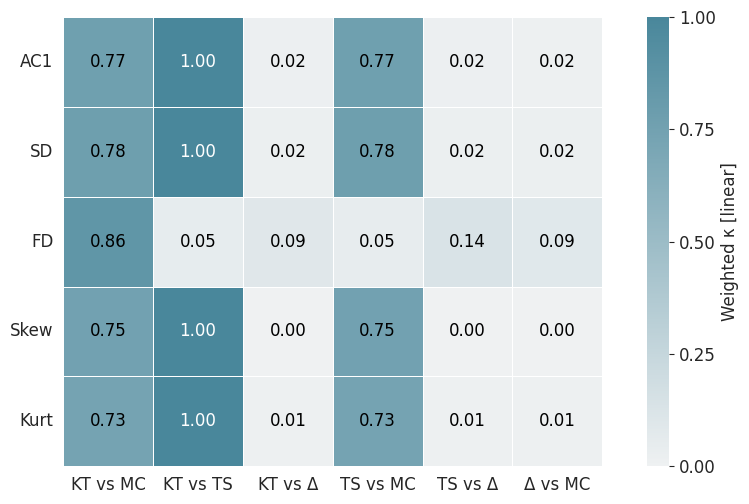

In [73]:
plot_agreement(df, df_agree, df_agree_pivot, cmap_seq)